<Figure size 1000x700 with 0 Axes>

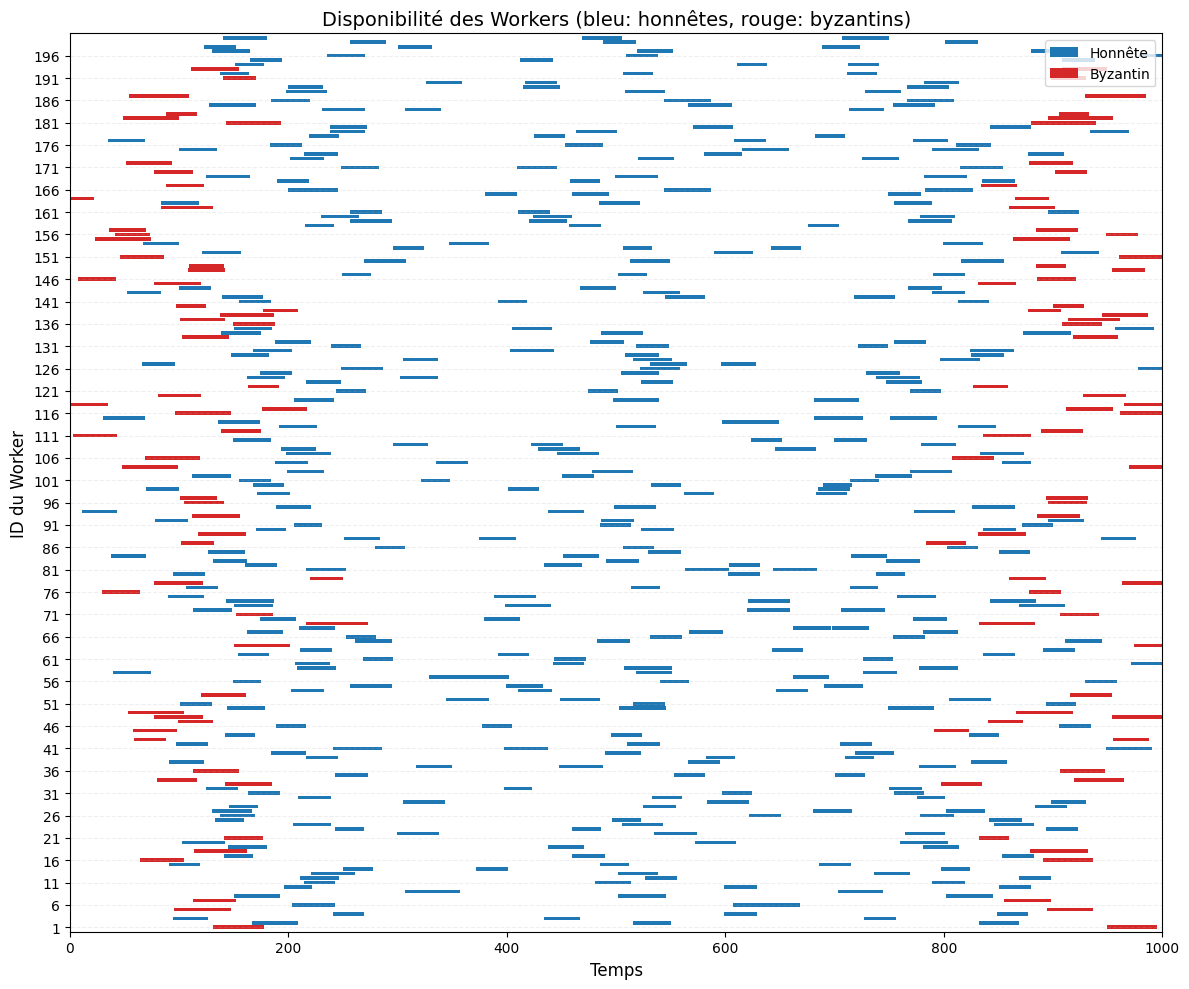

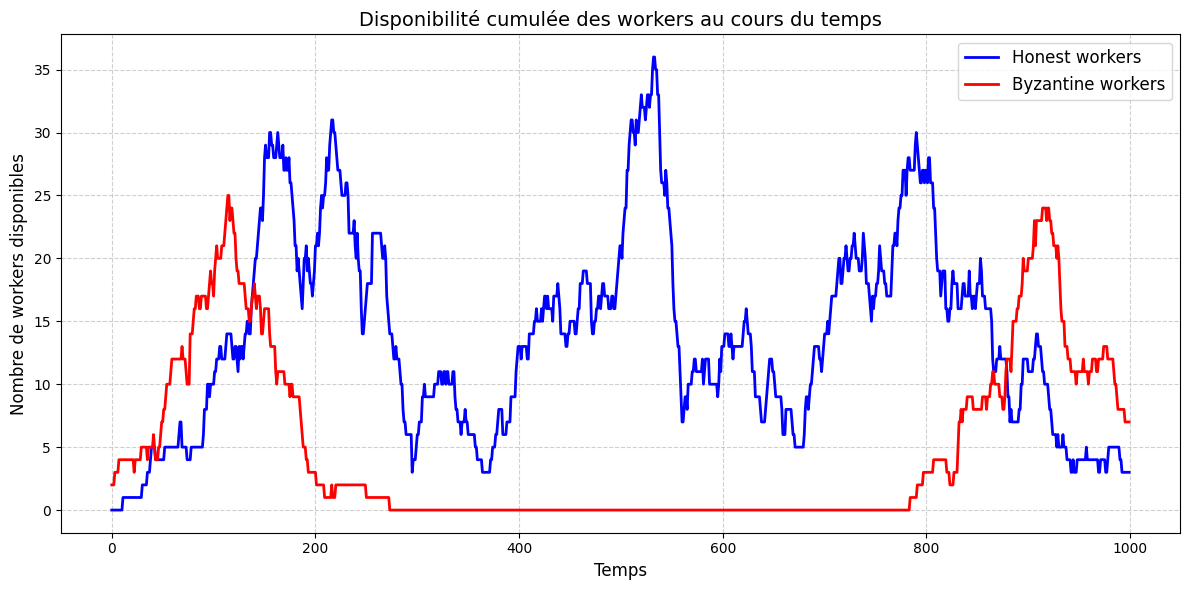

SafePoint initial — Accuracy: 9.68%
[t=16] Full batch 1 → acc 9.59%
[t=31] Full batch 2 → acc 9.59%
[t=41] Full batch 3 → acc 9.59%
ROLLBACK: Accuracy après rollback 9.68
[t=49] Full batch 4 → acc 9.59%
[t=55] Full batch 5 → acc 9.59%
[t=61] Full batch 6 → acc 9.59%
ROLLBACK: Accuracy après rollback 9.68
[t=66] Full batch 7 → acc 9.59%
[t=71] Full batch 8 → acc 9.59%
[t=79] Full batch 9 → acc 9.59%
ROLLBACK: Accuracy après rollback 9.68
[t=83] Full batch 10 → acc 9.59%
[t=91] Full batch 11 → acc 9.59%
[t=95] Full batch 12 → acc 9.59%
ROLLBACK: Accuracy après rollback 9.68
[t=100] Full batch 13 → acc 9.59%
[t=104] Full batch 14 → acc 9.59%
[t=108] Full batch 15 → acc 9.59%
ROLLBACK: Accuracy après rollback 9.68
[t=112] Full batch 16 → acc 9.59%
[t=116] Full batch 17 → acc 9.59%
[t=120] Full batch 18 → acc 9.59%
ROLLBACK: Accuracy après rollback 9.68
[t=124] Full batch 19 → acc 9.59%
[t=129] Full batch 20 → acc 9.59%
[t=134] Full batch 21 → acc 9.59%
ROLLBACK: Accuracy après rollback 9.6

KeyboardInterrupt: 

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import random
import numpy as np
import matplotlib.pyplot as plt
import byzfl
import torch.nn.functional as F
import copy
from torch.utils.data import random_split

# ------------------------------------------------------------------------------
# Fonctions utilitaires (inchangées)
def merge_intervals(intervals):
    if not intervals:
        return []
    intervals.sort()
    merged = [intervals[0]]
    for current in intervals[1:]:
        last = merged[-1]
        if current[0] <= last[1]:
            merged[-1] = (last[0], max(last[1], current[1]))
        else:
            merged.append(current)
    return merged

def generate_gaussian_availability(total_time_steps, worker_id, num_workers,
                                   std_dev_ratio=0.08, min_processing_time=3,
                                   smoothing_window=10):
    peak_means = [0.2, 0.5, 0.8]
    std_dev = int(std_dev_ratio * total_time_steps)
    availability_periods = []
    for mean_ratio in peak_means:
        mean = int(mean_ratio * total_time_steps)
        start_time = int(np.random.normal(loc=mean, scale=std_dev))
        start_time = max(0, min(start_time, total_time_steps - min_processing_time*3))
        duration = random.randint(min_processing_time*3,
                                  min(min_processing_time*5, total_time_steps - start_time))
        end_time = start_time + duration
        availability_periods.append((start_time, end_time))
    merged = merge_intervals(availability_periods)
    smoothed = []
    for s, e in merged:
        s2 = max(0, s - smoothing_window)
        e2 = min(total_time_steps, e + smoothing_window)
        smoothed.append((s2, e2))
    return merge_intervals(smoothed)

def generate_gaussian_byzantine_availability(
    total_time_steps, worker_id, num_workers,
    std_dev_ratio=0.05, min_processing_time=3,
    smoothing_window=10
):
    off_peak_means = [0.1, 0.9]
    std_dev = int(std_dev_ratio * total_time_steps)
    availability_periods = []
    for mean_ratio in off_peak_means:
        mean = int(mean_ratio * total_time_steps)
        start = int(np.random.normal(loc=mean, scale=std_dev))
        start = max(0, min(start, total_time_steps - min_processing_time*4))
        duration = random.randint(
            min_processing_time*4,
            min(min_processing_time*8, total_time_steps - start)
        )
        availability_periods.append((start, start + duration))
    merged = merge_intervals(availability_periods)
    smoothed = []
    for s, e in merged:
        s2 = max(0, s - smoothing_window)
        e2 = min(total_time_steps, e + smoothing_window)
        smoothed.append((s2, e2))
    return merge_intervals(smoothed)

# ------------------------------------------------------------------------------
# Modèle LeNet-like
class LeNetLike(nn.Module):
    def __init__(self):
        super(LeNetLike, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ------------------------------------------------------------------------------
# Gestionnaire de batch
class BatchManager:
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = list(range(len(dataset)))
        random.shuffle(self.indices)
        self.sampler = SubsetRandomSampler(self.indices)
        self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
    def get_next_batch(self):
        try:
            return next(self.loader)
        except StopIteration:
            random.shuffle(self.indices)
            self.sampler = SubsetRandomSampler(self.indices)
            self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
            return next(self.loader)

# ------------------------------------------------------------------------------
# Worker honnête
class Worker:
    def __init__(self, model, device, worker_id, availability_periods, processing_time):
        self.is_byzantine = False
        self.device = device
        self.worker_id = worker_id
        self.availability_periods = availability_periods
        self.processing_time = processing_time
        self.model = model.to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.finish_time = None
        self.current_batch_info = None
        self._pending = None

    def is_available(self, current_time):
        for start, end in self.availability_periods:
            if start <= current_time < end and (self.finish_time is None or current_time >= self.finish_time):
                return (current_time + self.processing_time) <= end
        return False

    def start_computation(self, current_time, batch_info, data, targets):
        # on prépare juste la tâche, sans lancer le calcul immédiat
        if self.current_batch_info != batch_info:
            self.current_batch_info = batch_info
            self.finish_time = current_time + self.processing_time
            self._pending = (data, targets)
        return None

    def has_finished(self, current_time):
        # dès que le délai arrive, on réalise le calcul
        if self.finish_time == current_time and self._pending is not None:
            data, targets = self._pending
            self._pending = None
            grads, bi = self.compute_gradient(data, targets)
            return True, grads, bi
        return False, None, None

    def compute_gradient(self, data, targets):
        data, targets = data.to(self.device), targets.to(self.device)
        self.model.zero_grad()
        outputs = self.model(data)
        loss = self.criterion(outputs, targets)
        loss.backward()
        gradients = {name: param.grad.detach().clone() for name, param in self.model.named_parameters()}
        return gradients, self.current_batch_info

    def update_model(self, model_state_dict):
        self.model.load_state_dict(model_state_dict)

# ------------------------------------------------------------------------------
# Worker byzantin
class ByzantineWorker(Worker):
    def __init__(self, model, device, worker_id, availability_periods, processing_time):
        super().__init__(model, device, worker_id, availability_periods, processing_time)
        self.is_byzantine = True

    def compute_gradient(self, data, targets):
        corrupted = {name: torch.full_like(param, 1e6) for name, param in self.model.named_parameters()}
        return corrupted, self.current_batch_info

# ------------------------------------------------------------------------------
# Serveur sans logique de vote
class Server:
    def __init__(self, dataset, batch_size=64, mini_batch_size=16, lr=0.005, verbose=False,
                 aggregation_strategy='trimmed_mean', f=0, preagg=None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = LeNetLike().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.batch_manager = BatchManager(dataset, batch_size)
        self.mini_batch_size = mini_batch_size
        self.current_batch_id = 0
        self.received_gradients = {}
        self.verbose = verbose
        self.aggregation_strategy = aggregation_strategy
        self.f = f
        self.preagg = preagg
        self.total_raw_compute_time = 0
        self.total_useful_compute_time = 0
        self.total_waste_compute_time = 0
        self.current_full_batch_compute_time = 0

    def get_new_complete_batch(self, current_time):
        data, targets = self.batch_manager.get_next_batch()
        self.current_batch_id += 1
        self.current_full_batch_compute_time = 0
        num = data.size(0)
        minibatches = [
            (data[i:i+self.mini_batch_size], targets[i:i+self.mini_batch_size])
            for i in range(0, num, self.mini_batch_size)
        ]
        self.current_mini_batches = {i: minibatches[i] for i in range(len(minibatches))}
        self.received_gradients = {}
        if self.verbose:
            print(f"[Temps {current_time}] Full batch {self.current_batch_id} préparé.")

    def register_gradient(self, gradients, batch_info, worker_id, current_time, worker_processing_time, is_byzantine=False):
        bid, mid = batch_info
        if bid != self.current_batch_id or mid in self.received_gradients:
            return
        self.total_raw_compute_time += worker_processing_time
        self.current_full_batch_compute_time += worker_processing_time
        self.received_gradients[mid] = gradients
        if self.verbose:
            tag = " (Byzantin)" if is_byzantine else ""
            print(f"[Temps {current_time}] Gradient mini-batch {mid} de worker {worker_id}{tag}.")

    def aggregate_and_update(self):
        if len(self.received_gradients) != len(self.current_mini_batches):
            if self.verbose:
                print("⚠️ Pas assez de gradients reçus.")
            return False

        pre = None
        if self.preagg == "NNM":
            pre = byzfl.NNM(f=self.f)
        elif self.preagg == "Bucketing":
            pre = byzfl.Bucketing(s=1)
        elif self.preagg == "ARC":
            pre = byzfl.ARC(f=self.f)

        aggs = {}
        for name, param in self.model.named_parameters():
            grads = [self.received_gradients[i][name] for i in sorted(self.current_mini_batches)]
            G = torch.stack(grads).view(len(grads), -1)
            if pre:
                G = pre(G)
            if self.aggregation_strategy == "trimmed_mean":
                agg_flat = byzfl.TrMean(f=max(self.f, (len(grads)//2)-1))(G)
            else:
                agg_flat = byzfl.Average()(G)
            aggs[name] = agg_flat.view(param.size())

        self.optimizer.zero_grad()
        for name, param in self.model.named_parameters():
            param.grad = aggs[name]
        self.optimizer.step()
        if self.verbose:
            print(f"Modèle mis à jour (batch {self.current_batch_id}).")
        return True

    def evaluate(self, eval_loader):
        self.model.eval()
        correct = total = 0
        with torch.no_grad():
            for d, t in eval_loader:
                d, t = d.to(self.device), t.to(self.device)
                out = self.model(d)
                pred = out.argmax(dim=1)
                total += t.size(0)
                correct += (pred == t).sum().item()
        return 100 * correct / total

    def report_compute_metrics(self):
        total = self.total_raw_compute_time
        useful = self.total_useful_compute_time
        waste = self.total_waste_compute_time
        rate = 100 * waste / total if total else 0
        print("\n📊 Rapport de temps de calcul :")
        print(f"- Temps brut total : {total}")
        print(f"- Temps utile      : {useful}")
        print(f"- Temps gaspillé   : {waste}")
        print(f"- Taux gaspillage  : {rate:.2f}%")

    def advance_decision(self, p1, p2, p3, sp, delta=2):
        if p1 == p2 == p3:
            return "rollback"
        conds = [
            p1>sp and p2>p1 and p3>sp+delta,
            p1>sp and p2<=p1 and p3>p1,
            p1<=sp and p2>sp and p3>p2,
            p1<=sp and p2>p1 and p2>sp and p3<p2 and p3>sp,
            p1<=sp and p2<=p1 and p3>sp
        ]
        return "accept" if any(conds) else "rollback"

# ------------------------------------------------------------------------------
def create_workers(num_worker, byzantine_indices_cycle, steps_per_cycle, server):
    workers = []
    for i in range(1, num_worker+1):
        pt = random.randint(2,5)
        if i in byzantine_indices_cycle:
            av = generate_gaussian_byzantine_availability(steps_per_cycle, i, num_worker, min_processing_time=pt)
            workers.append(ByzantineWorker(server.model, server.device, i, av, pt))
        else:
            av = generate_gaussian_availability(steps_per_cycle, i, num_worker, min_processing_time=pt)
            workers.append(Worker(server.model, server.device, i, av, pt))
    return workers

# ------------------------------------------------------------------------------
class SafePointSimulator:
    def __init__(self, server, workers, val_loader, test_loader, total_time_steps=1000, group_size=3):
        self.server = server
        self.workers = workers
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.total_time_steps = total_time_steps
        self.group_size = group_size
        self.global_time = 0
        self.in_progress_workers = []
        self.server.get_new_complete_batch(self.global_time)
        self.plot_worker_availability()

    def plot_worker_availability(self):
        """
        Affiche, pour chaque instant de temps, le nombre total de workers honnêtes (bleu)
        et Byzantins (rouge) disponibles.
        """

        num_workers = len(self.workers)
        fig_height = max(6, min(0.05 * num_workers, 20))
        fig, ax = plt.subplots(figsize=(12, fig_height))
        for worker in self.workers:
            color = "tab:red" if isinstance(worker, ByzantineWorker) else "tab:blue"
            for (start, end) in worker.availability_periods:
                ax.broken_barh([(start, end - start)], (worker.worker_id - 0.4, 0.8), facecolors=color)
        ax.set_xlabel("Temps", fontsize=12)
        ax.set_ylabel("ID du Worker", fontsize=12)
        ax.set_title("Disponibilité des Workers (bleu: honnêtes, rouge: byzantins)", fontsize=14)
        ax.set_xlim(0, self.total_time_steps)
        max_worker_id = max(worker.worker_id for worker in self.workers)
        ax.set_ylim(0, max_worker_id + 1)
        step = max(1, num_workers // 40)
        ax.set_yticks(list(range(1, max_worker_id + 1, step)))
        ax.grid(True, axis='y', linestyle='--', alpha=0.2)
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='tab:blue', label='Honnête'),
            Patch(facecolor='tab:red', label='Byzantin')
        ]
        ax.legend(handles=legend_elements, loc='upper right')
        plt.tight_layout()
        plt.show()


        # Initialiser deux tableaux pour compter séparément
        avail_honest = [0] * self.total_time_steps
        avail_byz   = [0] * self.total_time_steps

        for worker in self.workers:
            target = avail_byz if worker.is_byzantine else avail_honest
            for start, end in worker.availability_periods:
                for t in range(start, min(end, self.total_time_steps)):
                    target[t] += 1

        times = range(self.total_time_steps)
        plt.figure(figsize=(12, 6))
        plt.plot(times, avail_honest, label="Honest workers", color="blue", linewidth=2)
        plt.plot(times, avail_byz,   label="Byzantine workers", color="red",  linewidth=2)
        plt.xlabel("Temps", fontsize=12)
        plt.ylabel("Nombre de workers disponibles", fontsize=12)
        plt.title("Disponibilité cumulée des workers au cours du temps", fontsize=14)
        plt.legend(loc="upper right", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()


    def run(self, verbose=False, eval_interval=10):
        # sauvegarde du safe-point (modèle + optimiseur)
        safe_model = copy.deepcopy(self.server.model.state_dict())
        safe_opt   = copy.deepcopy(self.server.optimizer.state_dict())
        safe_acc   = self.server.evaluate(self.val_loader)
        print(f"SafePoint initial — Accuracy: {safe_acc:.2f}%")

        group_updates, group_times, decisions = [], [], []
        count = idx = 0
        time_points, acc_over_time = [], []
        k = 1

        while self.global_time < self.total_time_steps:
            # 1) récupération des workers qui ont fini
            for w in list(self.in_progress_workers):
                finished, grads, bi = w.has_finished(self.global_time)
                if not finished:
                    continue
                self.server.register_gradient(
                    grads, bi, w.worker_id, self.global_time,
                    w.processing_time, w.is_byzantine
                )
                self.in_progress_workers.remove(w)
                w.current_batch_info = None

            # 2) agrégation et mise à jour
            if len(self.server.received_gradients) == len(self.server.current_mini_batches):
                if self.server.aggregate_and_update():
                    acc = self.server.evaluate(self.val_loader)
                    print(f"[t={self.global_time}] Full batch {self.server.current_batch_id} → acc {acc:.2f}%")
                    group_updates.append(acc)
                    group_times.append(self.server.current_full_batch_compute_time)
                    count += 1
                    self.server.get_new_complete_batch(self.global_time)
                    self.in_progress_workers.clear()

                    if count == self.group_size:
                        decision = self.server.advance_decision(
                            group_updates[0], group_updates[1], group_updates[2], safe_acc
                        )
                        total_t = sum(group_times)
                        if decision == 'accept':
                            safe_model = copy.deepcopy(self.server.model.state_dict())
                            safe_opt   = copy.deepcopy(self.server.optimizer.state_dict())
                            safe_acc   = group_updates[2]
                            print("Mises à jour du groupe acceptées. Nouveau safe point établi.")
                            self.server.total_useful_compute_time += total_t
                        else:
                            self.server.model.load_state_dict(safe_model)
                            self.server.optimizer.load_state_dict(safe_opt)
                            acc_safe = self.server.evaluate(self.val_loader)
                            self.server.total_waste_compute_time += total_t
                            print(f"ROLLBACK: Accuracy après rollback {acc_safe:.2f}")
                        decisions.append((idx, decision, total_t))
                        group_updates.clear()
                        group_times.clear()
                        count = 0
                        idx += 1

            # 3) assignation des nouvelles tâches
            avail = [w for w in self.workers
                     if w.is_available(self.global_time)
                     and w not in self.in_progress_workers]
            for mi in sorted(self.server.current_mini_batches):
                if mi in self.server.received_gradients:
                    continue
                curr = len(self.server.received_gradients.get(mi, []))
                while curr < k and avail:
                    w = avail.pop(0)
                    w.update_model(copy.deepcopy(self.server.model.state_dict()))
                    data, tgt = self.server.current_mini_batches[mi]
                    w.start_computation(self.global_time,
                                        (self.server.current_batch_id, mi),
                                        data, tgt)
                    self.in_progress_workers.append(w)
                    curr += 1

            # 4) évaluation périodique
            if self.global_time % eval_interval == 0:
                at = self.server.evaluate(self.test_loader)
                acc_over_time.append(at)
                time_points.append(self.global_time)

            self.global_time += 1

        # restauration finale au safe-point
        self.server.model.load_state_dict(safe_model)
        self.server.optimizer.load_state_dict(safe_opt)

        final_acc = self.server.evaluate(self.test_loader)
        print(f"Final accuracy cycle: {final_acc:.2f}%")
        return final_acc


# ------------------------------------------------------------------------------
def run_experiment(num_cycles=2, num_runs=1, steps_per_cycle=1000,
                   byzantine_ratio=0.0, aggregation_strategy='trimmed_mean', preagg=None):
    results = []
    num_worker = 200
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Chargement complet de MNIST pour l'entraînement et le test
    full_train = datasets.MNIST(
        './data', train=True, download=True, transform=trans
    )
    test_ds = datasets.MNIST(
        './data', train=False, download=True, transform=trans
    )

    # Création des indices pour split train/val
    n_total = len(full_train)
    n_val   = int(0.20 * n_total)   # 20% pour validation
    perm = torch.randperm(n_total)
    val_indices   = perm[:n_val].tolist()
    train_indices = perm[n_val:].tolist()

    # DataLoaders avec SubsetRandomSampler
    train_loader = DataLoader(
        full_train, batch_size=640,
        sampler=SubsetRandomSampler(train_indices)
    )
    val_loader = DataLoader(
        full_train, batch_size=200,
        sampler=SubsetRandomSampler(val_indices)
    )
    test_loader = DataLoader(
        test_ds, batch_size=120, shuffle=False
    )

    for _ in range(num_runs):
        server = Server(
            train_loader.dataset,
            batch_size=640,
            mini_batch_size=64,
            verbose=False,
            aggregation_strategy=aggregation_strategy,
            preagg=preagg
        )

        for _ in range(num_cycles):
            byz = set(random.sample(
                range(1, num_worker+1),
                int(num_worker * byzantine_ratio)
            ))
            workers = create_workers(num_worker, byz, steps_per_cycle, server)

            sim = SafePointSimulator(
                server, workers,
                val_loader=val_loader,
                test_loader=test_loader,
                total_time_steps=steps_per_cycle,
                group_size=3
            )
            sim.run(verbose=False, eval_interval=20)
            server.report_compute_metrics()

        # évaluation finale sur le test set
        results.append(server.evaluate(test_loader))

    return np.mean(results)

# ------------------------------------------------------------------------------
if __name__ == "__main__":
    preagg_methods      = [None]
    aggregator_methods  = ["average"]
    byzantine_ratios    = [0.3, 0.4]
    num_runs            = 1
    num_cycles          = 1
    steps_per_cycle     = 1000

    for preagg in preagg_methods:
        plt.figure(figsize=(10,7))
        for agg in aggregator_methods:
            results = []
            for ratio in byzantine_ratios:
                acc = run_experiment(num_cycles=num_cycles,
                                     num_runs=num_runs,
                                     steps_per_cycle=steps_per_cycle,
                                     byzantine_ratio=ratio,
                                     aggregation_strategy=agg,
                                     preagg=preagg)
                results.append(acc)
                method_name = preagg if preagg is not None else "NoPreAgg"
                print(f"PreAgg: {method_name}, Aggregator: {agg}, Byzantine ratio: {ratio*100:.0f}%, Accuracy: {acc:.2f}%")
            plt.plot([r*100 for r in byzantine_ratios], results,
                     marker='o', linewidth=2, markersize=8, label=agg)
        title = f"Pre-aggregation: {preagg if preagg is not None else 'None'}"
        plt.xlabel("Taux de workers byzantins (%)", fontsize=14)
        plt.ylabel("Accuracy moyenne (%)",      fontsize=14)
        plt.title(title,                       fontsize=16)
        plt.legend(title="Aggregators",        fontsize=12, title_fontsize=13, loc="best")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.show()


j'aimerai rajouter une idée est de calculer en parallèle chaque fois le même batchs par 2 groupe de worker différents pour autant qu'ils sont disponible puis de prendre le meilleur on en laissant toujours la logique de la dvance decision avec 3 batchs traité
